# Quantum Machine Learning

Eigenvalue problem

In [1]:
import os
import qiskit

from qiskit import *

from qiskit_aer import Aer
from qiskit_aer import *

from qiskit.visualization import *

# SciPy minimizer routine
from scipy.optimize import minimize
import time
import numpy as np

from qiskit.quantum_info import SparsePauliOp

from qiskit.circuit.library import TwoLocal
from qiskit import QuantumCircuit


# Step 1. Map classical inputs to a quantum problem
$
\hat{\mathcal{H}}\ =\ 0.3980 \mathcal{Y}\mathcal{Z} - 0.3980 \mathcal{Z}\mathcal{I} - 0.0113 \mathcal{Z}\mathcal{Z} + 0.1810 \mathcal{X}\mathcal{X}$

In [2]:
hamiltonian = SparsePauliOp.from_list(
    [("YZ", 0.3980), ("ZI", -0.3980), ("ZZ", -0.0113), ("XX", 0.1810)]
)

In [3]:
def cost_func(params, ansatz, hamiltonian, estimator):
    """Return estimate of energy from estimator

    Parameters:
        params (ndarray): Array of ansatz parameters
        ansatz (QuantumCircuit): Parameterized ansatz circuit
        hamiltonian (SparsePauliOp): Operator representation of Hamiltonian
        estimator (Estimator): Estimator primitive instance

    Returns:
        float: Energy estimate
    """
    energy = estimator.run(ansatz, hamiltonian, parameter_values=params).result().values[0]
    return energy

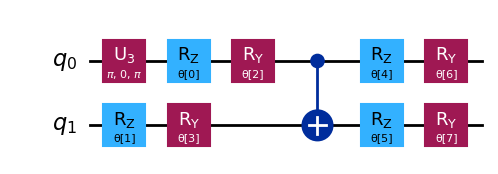

In [4]:
import numpy as np

reference_circuit = QuantumCircuit(2)
reference_circuit.x(0)

variational_form = TwoLocal(
    2,
    rotation_blocks=["rz", "ry"],
    entanglement_blocks="cx",
    entanglement="linear",
    reps=1,
)
ansatz = reference_circuit.compose(variational_form)

ansatz.decompose().draw('mpl')

# 2. Callback methods for better post processing

We can introcude methods that will be executed at each iteration in QuantumComputer

In [5]:
def build_callback(ansatz, hamiltonian, estimator, callback_dict):
    """Return callback function that uses Estimator instance,
    and stores intermediate values into a dictionary.

    Parameters:
        ansatz (QuantumCircuit): Parameterized ansatz circuit
        hamiltonian (SparsePauliOp): Operator representation of Hamiltonian
        estimator (Estimator): Estimator primitive instance
        callback_dict (dict): Mutable dict for storing values

    Returns:
        Callable: Callback function object
    """

    def callback(current_vector):
        """Callback function storing previous solution vector,
        computing the intermediate cost value, and displaying number
        of completed iterations and average time per iteration.

        Values are stored in pre-defined 'callback_dict' dictionary.

        Parameters:
            current_vector (ndarray): Current vector of parameters
                                      returned by optimizer
        """
        # Keep track of the number of iterations
        callback_dict["iters"] += 1
        # Set the prev_vector to the latest one
        callback_dict["prev_vector"] = current_vector
        # Compute the value of the cost function at the current vector
        # This adds an additional function evaluation
        current_cost = (
            estimator.run(ansatz, hamiltonian, parameter_values=current_vector).result().values[0]
        )
        callback_dict["cost_history"].append(current_cost)
        # Print to screen on single line
        print(
            "Iters. done: {} [Current cost: {}]".format(callback_dict["iters"], current_cost),
            end="\r",
            flush=True,
        )

    return callback


#### Initialize the callback_dict dictionary

In [6]:
callback_dict = {
    "prev_vector": None,
    "iters": 0,
    "cost_history": [],
}

In [7]:
num_params = ansatz.num_parameters
print(num_params)
x0 = 2 * np.pi * np.random.random(num_params)

8


# 3. Running In Simulator 

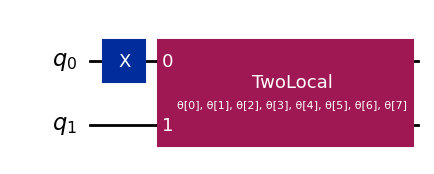

In [8]:
from qiskit import transpile
ansatz_sim=transpile(ansatz)
ansatz_sim.draw(output="mpl")

In [9]:
from qiskit.primitives import Estimator

backend = Aer.get_backend('qasm_simulator')

# x0 is the initial values of the parameters
x0 = np.ones(8) * np.pi/4



estimator = Estimator()
estimator.options.shots=512

callback = build_callback(ansatz, hamiltonian, estimator, callback_dict)

res = minimize(
    cost_func,
    x0,
    args=(ansatz, hamiltonian, estimator),
    method="cobyla",
    callback=callback
)



In [10]:
res

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -0.5544443710837298
       x: [ 1.869e+00  9.686e-01  2.872e-01  2.279e+00  2.174e+00
            2.280e+00  2.338e-01  6.422e-01]
    nfev: 71
   maxcv: 0.0

# 4. Post Processing

In [11]:
all(callback_dict["prev_vector"] == res.x)
callback_dict["iters"] == res.nfev

True

In [12]:
import matplotlib.pyplot as plt

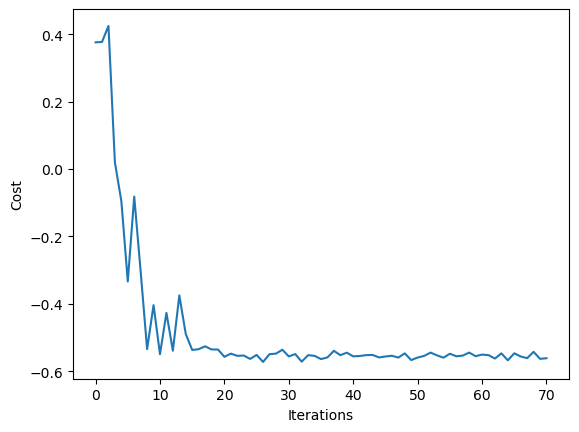

In [13]:
fig, ax = plt.subplots()
ax.plot(range(callback_dict["iters"]), callback_dict["cost_history"])
ax.set_xlabel("Iterations")
ax.set_ylabel("Cost")
plt.draw()